<a href="https://colab.research.google.com/github/AshwinDeshpande96/LANL-Earthquake-Prediction/blob/master/LANL_Earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Raw Data Fetching

In [158]:
#Get 'kaggle.json' file from your kaggle profile. Click on 'Edit Profile' --> 'Create New API Token'
#Upload 'kaggle.json' file
from google.colab import files
files.upload()

{}

In [159]:
#Make /root/.kaggle/ directory. So that kaggle command can download the data
!mkdir /root/.kaggle/
#Move downloaded 'kaggle.json' to previously created directory
!mv /content/kaggle.json /root/.kaggle/
#change permissions of 'kaggle.json' so that it is only accessible by you
!chmod 600 /root/.kaggle/kaggle.json
!ls /content/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
mv: cannot stat '/content/kaggle.json': No such file or directory
gdrive		       seg_428d66.csv  seg_848695.csv  seg_c23429.csv
sample_data	       seg_42c4c9.csv  seg_84a65d.csv  seg_c23641.csv
sample_submission.csv  seg_42e7e8.csv  seg_84b9d9.csv  seg_c243a6.csv
seg_00030f.csv	       seg_42ff14.csv  seg_84c7fb.csv  seg_c24946.csv
seg_0012b5.csv	       seg_430e66.csv  seg_84fc12.csv  seg_c25855.csv
seg_00184e.csv	       seg_43383f.csv  seg_8509db.csv  seg_c267a5.csv
seg_003339.csv	       seg_434c96.csv  seg_850d95.csv  seg_c26fb4.csv
seg_0042cc.csv	       seg_43597f.csv  seg_8515fd.csv  seg_c27591.csv
seg_004314.csv	       seg_43c6f4.csv  seg_853302.csv  seg_c2a0c8.csv
seg_004cd2.csv	       seg_440106.csv  seg_854d91.csv  seg_c2b8f7.csv
seg_004ee5.csv	       seg_4401d8.csv  seg_857304.csv  seg_c3507f.csv
seg_004f1f.csv	       seg_441c6d.csv  seg_85762d.csv  seg_c35940.csv
seg_00648a.csv	       seg_4435bd.csv  seg_8599ec.csv  

In [0]:
#download the Data given by Kaggle Competition
!kaggle competitions download -c LANL-Earthquake-Prediction
#this downloads 3 files: 
#1) sample_submisison.csv  
#2) test.zip - (this contains 2624 csv files with 150000 rows of acoustic_data)   
#3) train.csv.zip - Contains one csv file with approx 150000*4195 rows of ['acoustic_data', 'time_to_failure']
!ls

In [0]:
#extract train.csv.zip file to obtain train.csv file
!unzip train.csv.zip
!ls

In [0]:
#extract test.zip file to obtain 2624 'seg_******.csv' files
!unzip test.zip
!ls

In [0]:
#raw data sample
import pandas as pd
!
raw_sample = pd.read_csv('train.csv', nrows=5)
raw_sample.head()

# Feature Extraction

In [2]:
#Link up to Google Drive to store Extracted Feature Data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from sklearn.linear_model import LinearRegression
#this function returns a single feature: 'abs_trend'
def add_trend_feature(arr, abs_values=False):
    """Fit a univariate linear regression and return the coefficient."""
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]


In [0]:
def extract_features_from_segment(x):
    """Returns a dictionary with the features for the given segment of acoustic data."""
    features = {}
    
    features['ave'] = x.values.mean()
    features['std'] = x.values.std()
    features['max'] = x.values.max()
    features['min'] = x.values.min()
    features['q90'] = np.quantile(x.values, 0.90)
    features['q95'] = np.quantile(x.values, 0.95)
    features['q99'] = np.quantile(x.values, 0.99)
    features['q05'] = np.quantile(x.values, 0.05)
    features['q10'] = np.quantile(x.values, 0.10)
    features['q01'] = np.quantile(x.values, 0.01)
    features['std_to_mean'] = features['std'] / features['ave']
    
    features['abs_max'] = np.abs(x.values).max()
    features['abs_mean'] = np.abs(x.values).mean()
    features['abs_std'] = np.abs(x.values).std()
    features['trend'] = add_trend_feature(x.values)
    features['abs_trend'] = add_trend_feature(x.values, abs_values=True)
    
    # New features - rolling features
    for w in [10, 50, 100, 1000]:
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_min = x.rolling(w).min().dropna().values
        x_roll_max = x.rolling(w).max().dropna().values
        
        features['ave_roll_std_' + str(w)] = x_roll_std.mean()
        features['std_roll_std_' + str(w)] = x_roll_std.std()
        features['max_roll_std_' + str(w)] = x_roll_std.max()
        features['min_roll_std_' + str(w)] = x_roll_std.min()
        features['q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        features['q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        features['q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        features['q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        features['q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        
        features['ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        features['std_roll_mean_' + str(w)] = x_roll_mean.std()
        features['max_roll_mean_' + str(w)] = x_roll_mean.max()
        features['min_roll_mean_' + str(w)] = x_roll_mean.min()
        features['q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        features['q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        
        features['ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        features['std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        features['q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        features['q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        
        features['std_roll_min_' + str(w)] = x_roll_min.std()
        features['max_roll_min_' + str(w)] = x_roll_min.max()
        features['q05_roll_min_' + str(w)] = np.quantile(x_roll_min, 0.05)
        features['q95_roll_min_' + str(w)] = np.quantile(x_roll_min, 0.95)

        features['std_roll_max_' + str(w)] = x_roll_max.std()
        features['min_roll_max_' + str(w)] = x_roll_max.min()
        features['q05_roll_max_' + str(w)] = np.quantile(x_roll_max, 0.05)
        features['q95_roll_max_' + str(w)] = np.quantile(x_roll_max, 0.95)
    return features

In [0]:
import pandas as pd
import time as t
import os
#Feature Extraction found at https://www.kaggle.com/jsaguiar/baseline-with-multiple-models
#make_train function returns a 3 things:
#!) X_train - Training Set of shape (4195 * 124) - Each of 4195 rows is contructed by calling 'extract_features_from_segment' function from 150,000 data-chunk of train.csv file
#2) target - target variable is the value of every 150,000th  train.csv's ['time_to_failure'] data
#3) quake - not used in this project
def make_train():
    features_list = []
    target_list = []
    quake_num = []
    quake_count = 0
    row = 1
    time_so_far = 0
    for segment in pd.read_csv('/content/train.csv', chunksize=150000):
        
        start = t.time()
        
        target_list.append(segment['time_to_failure'].values[-1])
        features_list.append(extract_features_from_segment(segment['acoustic_data']))
        quake_num.append(quake_count)
        
        if any(segment['time_to_failure'].diff() > 5):
            quake_count = quake_count + 1
        
        end = t.time()
        
        time_taken = end - start
        time_so_far += time_taken
        
        print "\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b", row, "/4195 \n ETA: ", round(time_so_far/60, 1), "m/", int(time_taken*4195/60), 'm'
        
        row = row + 1
    return pd.DataFrame(features_list), pd.Series(target_list), pd.Series(quake_num)
#reads each 2624 'seg_******.csv' file and creates a (2624*124) dataset for testing
def make_test():
    features_list = []
    
    row = 1
    time_so_far = 0
    test_files = [file for file in os.listdir(os.getcwd()) if file.startswith("seg")]          #returns an array of every seg_******.csv file in current directory
    num_test_file = len(test_files)
    for file in test_files:
        segment = pd.read_csv(file)
        start = t.time()
        
        
        features_list.append(extract_features_from_segment(segment['acoustic_data']))
        
        
        end = t.time()
        
        time_taken = end - start
        time_so_far += time_taken
        
        print "\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b", row, "\b/" +str(num_test_file)+"\nETA: ", round(time_so_far/60, 1), "\bm/", int(time_taken*num_test_file/60), 'm'
        
        row = row + 1
    return pd.DataFrame(features_list)


In [0]:
X_train, target, quake = make_train()

In [165]:
#X_train, target, quake is created

print "Train shape:", X_train.shape, "\n", X_train.head(3)
print "Target shape:", target.shape, "\n", target.head(3)
print "Quake shape:", quake.shape, "\n", quake.head(3), 


Train shape: (4195, 124) 
   abs_max  abs_mean   abs_std  ...  std_roll_std_50  std_to_mean         trend
0      104  5.576567  4.333310  ...         3.176148     1.044425 -3.268300e-06
1      181  5.734167  5.732758  ...         4.953472     1.394229  9.090424e-07
2      140  6.152647  5.895925  ...         5.035827     1.420060  3.962182e-06

[3 rows x 124 columns]
Target shape: (4195,) 
0    1.430797
1    1.391499
2    1.353196
dtype: float64
Quake shape: (4195,) 
0    0
1    0
2    0
dtype: int64


In [167]:
#files are saved onto Google Drive in csv format with X_train - (4195*550) rows & colums, target with (4195, 1) rows & columns, quake with (4195, 1) rows & columns
#change filepath according to your drive directory
X_train.to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/X_train.csv", index=False)
target.to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/target.csv", index=False)
#quake.to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/quake.csv", index=False)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [168]:
#test_set is created
testset = make_test()
#files are saved onto Google Drive in csv format with test_set.csv - (2624*124) rows & colums
testset.to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/test_set.csv", index=False)

 1 /2624
ETA:  0.0 m/ 9 m
 2 /2624
ETA:  0.0 m/ 10 m
 3 /2624
ETA:  0.0 m/ 10 m
 4 /2624
ETA:  0.0 m/ 10 m
 5 /2624
ETA:  0.0 m/ 10 m
 6 /2624
ETA:  0.0 m/ 10 m
 7 /2624
ETA:  0.0 m/ 10 m
 8 /2624
ETA:  0.0 m/ 11 m
 9 /2624
ETA:  0.0 m/ 10 m
 10 /2624
ETA:  0.0 m/ 10 m
 11 /2624
ETA:  0.0 m/ 10 m
 12 /2624
ETA:  0.0 m/ 10 m
 13 /2624
ETA:  0.1 m/ 10 m
 14 /2624
ETA:  0.1 m/ 10 m
 15 /2624
ETA:  0.1 m/ 10 m
 16 /2624
ETA:  0.1 m/ 10 m


Once X-train.csv, target.csv, quake.csv, test_set.csv are created we do not have to run previous cells again. 
Further program uses only the data saved in csv file in Google drive

# Data Import

In [0]:
#We start by importing previously created csv files
import pandas as pd
X = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/X_train.csv")
Y = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/target.csv", header=None)
#Uncomment if you want to use quake data
#quake = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/quake.csv")

In [4]:
#X_train.drop(X_train.tail(1).index,inplace=True)
print "Training Data:\t", X.shape
print "  Target Data:\t", Y.shape

#Display sample of training data
X.head(5)


Training Data:	(4195, 124)
  Target Data:	(4195, 1)


,abs_max,abs_mean,abs_std,abs_trend,ave,ave_roll_abs_mean_10,ave_roll_abs_mean_100,ave_roll_abs_mean_1000,ave_roll_abs_mean_50,ave_roll_mean_10,ave_roll_mean_100,ave_roll_mean_1000,ave_roll_mean_50,ave_roll_std_10,ave_roll_std_100,ave_roll_std_1000,ave_roll_std_50,max,max_roll_mean_10,max_roll_mean_100,max_roll_mean_1000,max_roll_mean_50,max_roll_min_10,max_roll_min_100,max_roll_min_1000,max_roll_min_50,max_roll_std_10,max_roll_std_100,max_roll_std_1000,max_roll_std_50,min,min_roll_max_10,min_roll_max_100,min_roll_max_1000,min_roll_max_50,min_roll_mean_10,min_roll_mean_100,min_roll_mean_1000,min_roll_mean_50,min_roll_std_10,...,q95_roll_mean_10,q95_roll_mean_100,q95_roll_mean_1000,q95_roll_mean_50,q95_roll_min_10,q95_roll_min_100,q95_roll_min_1000,q95_roll_min_50,q95_roll_std_10,q95_roll_std_100,q95_roll_std_1000,q95_roll_std_50,q99,q99_roll_std_10,q99_roll_std_100,q99_roll_std_1000,q99_roll_std_50,std,std_roll_abs_mean_10,std_roll_abs_mean_100,std_roll_abs_mean_1000,std_roll_abs_mean_50,std_roll_max_10,std_roll_max_100,std_roll_max_1000,std_roll_max_50,std_roll_mean_10,std_roll_mean_100,std_roll_mean_1000,std_roll_mean_50,std_roll_min_10,std_roll_min_100,std_roll_min_1000,std_roll_min_50,std_roll_std_10,std_roll_std_100,std_roll_std_1000,std_roll_std_50,std_to_mean,trend
0,104,5.576567,4.333310,-0.000011,4.884113,5.576566,5.576655,5.579118,5.576561,4.884088,4.883864,4.883418,4.883969,3.507118,4.050450,4.288590,4.011743,104,68.5,10.04,5.629,12.82,32.0,1.0,-2.0,3.0,78.313047,52.335255,31.029445,61.404926,-98,-18.0,8.0,12.0,7.0,-60.0,1.04,3.896,-3.10,0.421637,...,8.1,5.58,5.338,5.80,4.0,-1.0,-3.0,0.0,7.226494,8.195903,8.185756,8.310922,18.0,15.034220,16.948797,15.055998,17.430339,5.101089,2.897799,2.193084,1.612370,2.302065,4.568265,6.594138,11.064159,5.891685,2.801800,0.452294,0.295715,0.606039,4.526280,6.522304,11.248606,5.787738,2.809071,3.111524,2.769772,3.176148,1.044425,-3.268300e-06
1,181,5.734167,5.732758,-0.000005,4.725767,5.734187,5.734653,5.739510,5.734444,4.725732,4.725623,4.724876,4.725729,3.761435,4.436359,4.843486,4.379248,181,145.1,16.67,5.667,28.26,91.0,1.0,-2.0,2.0,122.978273,87.972617,38.643217,94.730087,-154,-99.0,8.0,11.0,7.0,-128.0,-4.09,3.412,-13.30,0.421637,...,8.2,5.39,5.066,5.64,4.0,-1.0,-3.0,0.0,8.265726,9.829922,10.544982,9.882948,21.0,18.772705,23.457270,33.704332,23.233021,6.588802,4.403190,3.563252,2.399157,3.752625,6.615549,10.727877,21.604075,9.299945,3.924070,0.496220,0.231587,0.764507,6.398675,10.162552,21.096014,8.823748,4.120785,4.893431,4.492905,4.953472,1.394229,9.090424e-07
2,140,6.152647,5.895925,0.000010,4.906393,6.152557,6.153045,6.159850,6.152678,4.906229,4.906088,4.905840,4.906072,4.080841,4.917334,5.423013,4.849219,140,94.8,12.38,5.957,17.36,60.0,2.0,-2.0,2.0,96.247424,53.353832,35.326896,65.431379,-106,-33.0,8.0,11.0,7.0,-72.9,-1.55,4.055,-7.72,0.516398,...,9.1,5.66,5.344,5.94,4.0,-1.0,-3.0,0.0,10.211649,13.485267,14.845834,13.127670,26.0,23.865014,28.598375,23.928873,29.448105,6.967374,4.429093,3.516817,2.414414,3.699345,6.789628,10.729778,19.898844,9.372244,4.179729,0.530151,0.267012,0.811309,6.641086,10.535572,19.047827,9.125804,4.227960,4.959233,4.402140,5.035827,1.420060,3.962182e-06
3,199,5.933960,6.061193,-0.000002,4.902240,5.933982,5.934187,5.939037,5.933995,4.902291,4.901946,4.901486,4.902059,3.788192,4.533343,4.939280,4.475839,197,125.3,18.26,5.858,27.72,63.0,2.0,-1.0,3.0,141.450580,103.996664,52.805653,113.368462,-199,-50.0,8.0,12.0,7.0,-136.6,-9.37,3.722,-18.86,0.516398,...,8.5,5.61,5.317,5.88,4.0,0.0,-3.0,0.0,8.380533,10.367490,11.715642,10.503576,22.0,19.249384,26.380301,21.950987,25.757986,6.922282,4.692604,3.913703,2.782407,4.065653,7.088646,11.203181,20.417531,9.908524,4.299460,0.581874,0.266700,0.959834,6.695330,10.524292,20.248763,9.217610,4.284176,5.247130,4.873523,5.285204,1.412065,1.637207e-06
4,145,6.110587,6.329464,0.000005,4.908720,6.110644,6.111666,6.111178,6.111119,4.908728,4.909175,4.910196,4.908958,3.835604,4.761149,5.121868,4.700727,145,107.6,14.41,6.07

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4195 entries, 0 to 4194
Columns: 124 entries, abs_max to trend
dtypes: float64(121), int64(3)
memory usage: 4.0 MB


In [6]:
X.describe()

,abs_max,abs_mean,abs_std,abs_trend,ave,ave_roll_abs_mean_10,ave_roll_abs_mean_100,ave_roll_abs_mean_1000,ave_roll_abs_mean_50,ave_roll_mean_10,ave_roll_mean_100,ave_roll_mean_1000,ave_roll_mean_50,ave_roll_std_10,ave_roll_std_100,ave_roll_std_1000,ave_roll_std_50,max,max_roll_mean_10,max_roll_mean_100,max_roll_mean_1000,max_roll_mean_50,max_roll_min_10,max_roll_min_100,max_roll_min_1000,max_roll_min_50,max_roll_std_10,max_roll_std_100,max_roll_std_1000,max_roll_std_50,min,min_roll_max_10,min_roll_max_100,min_roll_max_1000,min_roll_max_50,min_roll_mean_10,min_roll_mean_100,min_roll_mean_1000,min_roll_mean_50,min_roll_std_10,...,q95_roll_mean_10,q95_roll_mean_100,q95_roll_mean_1000,q95_roll_mean_50,q95_roll_min_10,q95_roll_min_100,q95_roll_min_1000,q95_roll_min_50,q95_roll_std_10,q95_roll_std_100,q95_roll_std_1000,q95_roll_std_50,q99,q99_roll_std_10,q99_roll_std_100,q99_roll_std_1000,q99_roll_std_50,std,std_roll_abs_mean_10,std_roll_abs_mean_100,std_roll_abs_mean_1000,std_roll_abs_mean_50,std_roll_max_10,std_roll_max_100,std_roll_max_1000,std_roll_max_50,std_roll_mean_10,std_roll_mean_100,std_roll_mean_1000,std_roll_mean_50,std_roll_min_10,std_roll_min_100,std_roll_min_1000,std_roll_min_50,std_roll_std_10,std_roll_std_100,std_roll_std_1000,std_roll_std_50,std_to_mean,trend
count,4195.000000,4195.000000,4195.000000,4.195000e+03,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,...,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4.195000e+03
mean,170.046246,5.547367,5.750146,2.827748e-07,4.519475,5.547369,5.547399,5.547748,5.547382,4.519477,4.519478,4.519456,4.519477,3.670175,4.324123,4.651123,4.274215,163.522288,107.347986,13.815514,5.643794,20.947399,53.713945,1.063886,-2.190226,2.286293,115.372559,76.680334,40.591248,88.130732,-149.190942,-43.518713,7.963766,11.233611,6.734446,-94.670656,-4.217924,3.472437,-10.853921,0.501022,...,7.861728,5.201020,4.921990,5.440055,3.247914,-0.839094,-3.473421,0.047676,7.805958,9.649532,10.841457,9.500056,20.321890,19.479767,25.398655,25.955050,25.097586,6.547766,4.289140,3.472697,2.548501,3.629211,6.391825,10.353373,19.190201,8.999241,3.889181,0.534752,0.253687,0.818008,6.325199,10.151561,18.635940,8.845749,3.953465,4.716218,4.341253,4.770913,1.452344,9.810856e-09
std,296.887015,1.517038,8.339184,2.816430e-05,0.256049,1.517101,1.517714,1.524615,1.517372,0.256047,0.256051,0.256134,0.256048,1.286996,1.995046,2.204306,1.943615,272.930331,198.948002,24.602328,3.144851,43.898445,120.136779,0.421433,0.519115,0.627832,181.270841,130.969943,85.319499,150.677020,265.087984,127.252614,0.416199,0.521603,0.808304,197.432199,21.785600,2.376465,40.415492,0.071198,...,1.620100,0.304166,0.275659,0.364587,0.437340,0.449762,0.589971,0.390781,3.998553,5.754333,6.156917,5.650436,14.225526,24.840843,44.896078,52.294420,42.489372,8.503911,7.539301,6.830866,6.326787,6.957670,9.730772,17.772693,29.216820,15.324424,6.419866,0.836701,0.156512,1.597011,9.647006,17.534942,28.564712,15.154531,5.885327,8.395670,8.389641,8.335026,1.877547,1.863566e-06
min,23.000000,4.147707,2.589077,-6.957745e-04,3.596313,4.147750,4.147914,4.148826,4.147811,3.596504,3.596501,3.596077,3.596527,2.577061,2.745880,2.773865,2.735844,23.000000,14.300000,5.610

#  Training

In [7]:
#import required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import load_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#split the training and target data into 3/4 for training and 1/4 for validation. Choose your split with test_size= values ranging from [0,1] percentage of data
x_train, x_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.2, random_state=42)

In [10]:
#We create a Fully Connected Dense Net Initial width 83 and Depth of 2 layers each activated by relu besides the last(output layer) as this is a regression type neural network
model = Sequential()
model.add(Dense(83 , input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(38,  kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
model.compile(loss='logcosh', optimizer=Adam(lr=1.0e-3))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
filepath = "/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/weights.hdf5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),                                   #Stop training if no improvement is seen in Validation loss after 10 attempts
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta=1.5e-5, patience=5, verbose=1, mode='min'),                    #Slow down Learning rate if Validation Loss is not Decreasing after 5 attempts
    ModelCheckpoint(filepath, save_best_only=True,  save_weights_only=False, monitor='val_loss', mode='min', verbose=1) #Best Model weights are saved in hdf5 file every epoch
]
#model = load_model('/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/model.hdf5')
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, callbacks=callbacks, verbose=1) #Train Model
model.save('/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/model.hdf5')      #Save Trained model after training

Instructions for updating:
Use tf.cast instead.
Train on 3356 samples, validate on 839 samples
Epoch 1/100
3356/3356 [==============================] - 3s 1ms/step - loss: 2.6212 - val_loss: 1.8508

Epoch 00001: val_loss improved from inf to 1.85083, saving model to /content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/weights.hdf5
Epoch 2/100
3356/3356 [==============================] - 1s 203us/step - loss: 2.0584 - val_loss: 1.8193

Epoch 00002: val_loss improved from 1.85083 to 1.81934, saving model to /content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/weights.hdf5
Epoch 3/100
3356/3356 [==============================] - 1s 199us/step - loss: 1.9444 - val_loss: 1.8171

Epoch 00003: val_loss improved from 1.81934 to 1.81710, saving model to /content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/weights.hdf5
Epoch 4/100
3356/3356 [==============================] - 1s 206us/step - loss: 1.8864 - val_loss: 1.9

# Testing

In [13]:
test_files = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission.csv")['seg_id']                 #Get all Test Segments Names for printing name and it's prediction
test_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/test_set.csv")                    #Read Test Data
print test_df.values.shape

(2624, 124)


In [0]:
#model = load_model('/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/model.hdf5')                         #Load Trained Model                                                                                                   
model.load_weights(filepath)
ynew = model.predict(test_df.values)
#print len(ynew), len(test_files)
#Predict Y value('time_to_failure') for every 2624 row
submission = []                                                                                                                         #Array to save Segment and it's prediction
for i in range(len(ynew)):
    submission.append( {"seg_id":test_files[i], "time_to_failure":ynew[i][0]})                                                          #Save every segment and it's prediction in submission array
pd.DataFrame(submission).to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission.csv", index=False) #Save Predictions in a csv file

In [16]:
import pandas as pd
submission_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission.csv")           #Read Saved Submission File
print submission_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

       seg_id  time_to_failure
0  seg_63c8e4         4.287015
1  seg_5f352e         6.679944
2  seg_8fc754         6.407549
3  seg_f7290f         2.617933
4  seg_2383c2         2.937188


# XGBOOST

In [39]:
import xgboost as xgb

x_train, x_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)
param = {'max_depth' : 3, 'eta' : 0.1, 'seed' : 42}
num_round = 30
bst = xgb.train(param, dtrain, num_round, [(dtest, 'test'), (dtrain, 'train')])

[0]	test-rmse:5.82374	train-rmse:5.83747
[1]	test-rmse:5.37153	train-rmse:5.37963
[2]	test-rmse:4.97403	train-rmse:4.97736
[3]	test-rmse:4.62717	train-rmse:4.62486
[4]	test-rmse:4.32581	train-rmse:4.31802
[5]	test-rmse:4.062	train-rmse:4.05112
[6]	test-rmse:3.83602	train-rmse:3.8209
[7]	test-rmse:3.6405	train-rmse:3.62259
[8]	test-rmse:3.47592	train-rmse:3.45174
[9]	test-rmse:3.33394	train-rmse:3.30712
[10]	test-rmse:3.21397	train-rmse:3.18374
[11]	test-rmse:3.11224	train-rmse:3.079
[12]	test-rmse:3.02695	train-rmse:2.99129
[13]	test-rmse:2.96007	train-rmse:2.91636
[14]	test-rmse:2.90161	train-rmse:2.85426
[15]	test-rmse:2.85214	train-rmse:2.8021
[16]	test-rmse:2.81324	train-rmse:2.75765
[17]	test-rmse:2.77857	train-rmse:2.71883
[18]	test-rmse:2.75118	train-rmse:2.68554
[19]	test-rmse:2.72846	train-rmse:2.65852
[20]	test-rmse:2.71037	train-rmse:2.63511
[21]	test-rmse:2.69638	train-rmse:2.6163
[22]	test-rmse:2.68416	train-rmse:2.59931
[23]	test-rmse:2.67351	train-rmse:2.58537
[24]	test-

In [41]:
from sklearn.metrics import accuracy_score
test_mat = xgb.DMatrix(test_df.values)
preds = bst.predict(test_mat)
print len(preds)

2624


In [0]:
submission_xgboost = []                                                                                                                         #Array to save Segment and it's prediction
for i in range(len(preds)):
    submission_xgboost.append( {"seg_id":test_files[i], "time_to_failure":preds[i]})                                                          #Save every segment and it's prediction in submission array
pd.DataFrame(submission_xgboost).to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission_xgboost.csv", index=False) #Save Predictions in a csv file

In [43]:
submission_xgb_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission_xgboost.csv")           #Read Saved Submission File
print submission_xgb_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

       seg_id  time_to_failure
0  seg_63c8e4         7.181951
1  seg_5f352e         7.638313
2  seg_8fc754         7.260017
3  seg_f7290f         4.656446
4  seg_2383c2         3.893890


# LightGBM

In [44]:
import lightgbm
#categorical_features = [c for c, col in enumerate(X.columns) if 'cat' in col]
#print categorical_features
#
# Train the model
#
#split the training and target data into 3/4 for training and 1/4 for validation. Choose your split with test_size= values ranging from [0,1] percentage of data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


evals_result = {}

train_data = lightgbm.Dataset(x_train, y_train)
test_data = lightgbm.Dataset(x_test, y_test)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'huber',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose':0
}

gbm = lightgbm.train(params, train_data, num_boost_round=100, valid_sets=test_data, early_stopping_rounds=10, evals_result=evals_result)

[1]	valid_0's huber: 2.3069
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's huber: 2.24105
[3]	valid_0's huber: 2.1785
[4]	valid_0's huber: 2.12132
[5]	valid_0's huber: 2.07184
[6]	valid_0's huber: 2.02235
[7]	valid_0's huber: 1.97846
[8]	valid_0's huber: 1.93968
[9]	valid_0's huber: 1.90245
[10]	valid_0's huber: 1.87051
[11]	valid_0's huber: 1.8405
[12]	valid_0's huber: 1.81253
[13]	valid_0's huber: 1.7882
[14]	valid_0's huber: 1.76641
[15]	valid_0's huber: 1.74477
[16]	valid_0's huber: 1.72787
[17]	valid_0's huber: 1.71233
[18]	valid_0's huber: 1.69622
[19]	valid_0's huber: 1.68242
[20]	valid_0's huber: 1.66906
[21]	valid_0's huber: 1.65918
[22]	valid_0's huber: 1.64657
[23]	valid_0's huber: 1.63885
[24]	valid_0's huber: 1.62964
[25]	valid_0's huber: 1.61983
[26]	valid_0's huber: 1.61316
[27]	valid_0's huber: 1.60526
[28]	valid_0's huber: 1.60155
[29]	valid_0's huber: 1.59567
[30]	valid_0's huber: 1.5927
[31]	valid_0's huber: 1.58855
[32]	valid_0's huber: 

In [45]:
test_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/test_set_550.csv")                    #Read Test Data
y_pred=gbm.predict(test_df)
print y_pred[:5]

[4.07423077 6.15674946 5.54159488 6.2706678  5.9118531 ]


In [0]:
test_files = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission.csv")['seg_id']                 #Get all Test Segments Names for printing name and it's prediction
submission_lightgbm = []                                                                                                                         #Array to save Segment and it's prediction
for i in range(len(y_pred)):
    submission_lightgbm.append( {"seg_id":test_files[i], "time_to_failure":y_pred[i]})                                                          #Save every segment and it's prediction in submission array
pd.DataFrame(submission_lightgbm).to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission_lightgbm.csv", index=False) #Save Predictions in a csv file

In [47]:
submission_lightgbm_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission_lightgbm.csv")           #Read Saved Submission File
print submission_lightgbm_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

       seg_id  time_to_failure
0  seg_63c8e4         4.074231
1  seg_5f352e         6.156749
2  seg_8fc754         5.541595
3  seg_f7290f         6.270668
4  seg_2383c2         5.911853


# Output

In [51]:
print "Neural Network with 124 features"
submission_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission.csv")           #Read Saved Submission File
print submission_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

Neural Network with 124 features
       seg_id  time_to_failure
0  seg_63c8e4         4.287015
1  seg_5f352e         6.679944
2  seg_8fc754         6.407549
3  seg_f7290f         2.617933
4  seg_2383c2         2.937188


In [52]:
print "Neural Network with 550 features"
submission_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission_550.csv")           #Read Saved Submission File
print submission_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

Neural Network with 550 features
       seg_id  time_to_failure
0  seg_63c8e4         4.287015
1  seg_5f352e         6.679944
2  seg_8fc754         6.407549
3  seg_f7290f         2.617933
4  seg_2383c2         2.937188


In [53]:
print "XGBoost"
submission_xgb_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission_xgboost.csv")           #Read Saved Submission File
print submission_xgb_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

XGBoost
       seg_id  time_to_failure
0  seg_63c8e4         7.181951
1  seg_5f352e         7.638313
2  seg_8fc754         7.260017
3  seg_f7290f         4.656446
4  seg_2383c2         3.893890


In [54]:
print "LightGBM"
submission_lightgbm_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission_lightgbm.csv")           #Read Saved Submission File
print submission_lightgbm_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

LightGBM
       seg_id  time_to_failure
0  seg_63c8e4         4.074231
1  seg_5f352e         6.156749
2  seg_8fc754         5.541595
3  seg_f7290f         6.270668
4  seg_2383c2         5.911853


# Visualization

XGBOOST


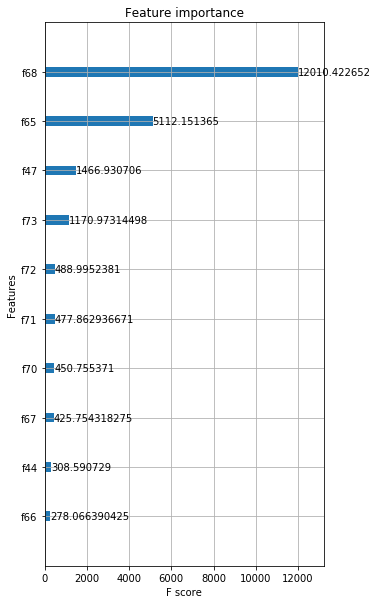

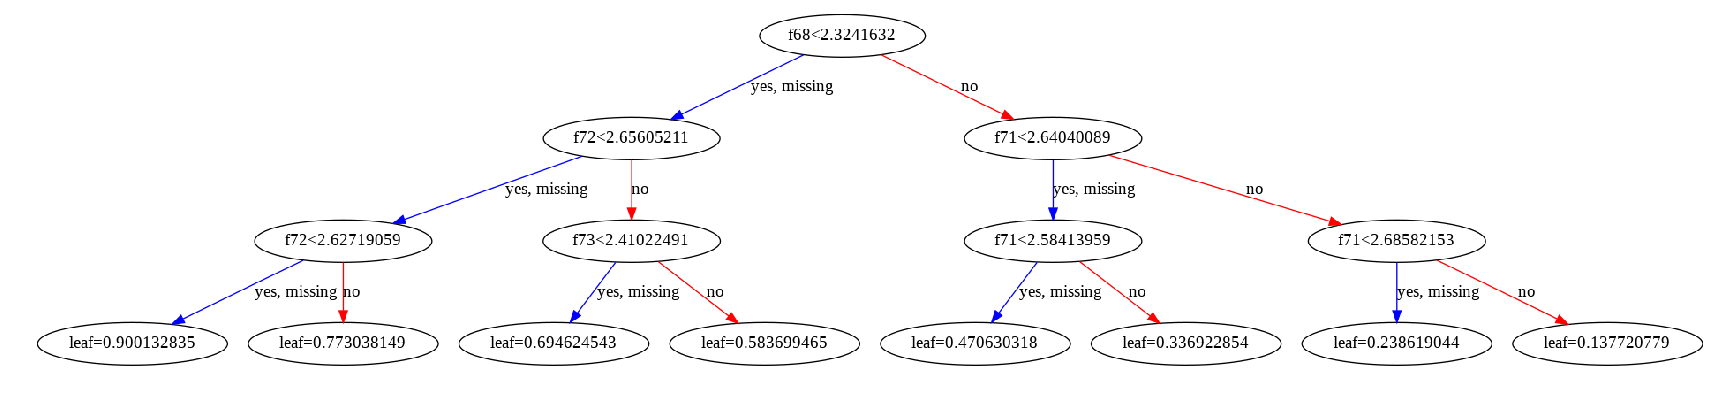

In [55]:
from xgboost import plot_tree
print "XGBOOST"
fig, ax = plt.subplots(figsize=(5, 10))

x = xgb.plot_importance(bst, importance_type='gain', max_num_features=10, ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(30, 120))
xgb.plot_tree(bst, num_trees=0, ax=ax)
plt.show()

LightGBM
Plotting metrics recorded during training...


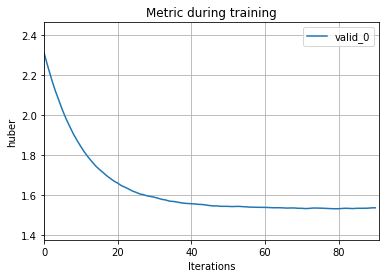

Plotting feature importances...


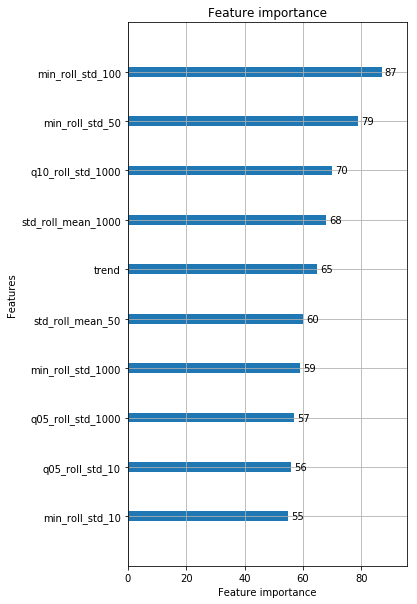

Plotting tree with graphviz...


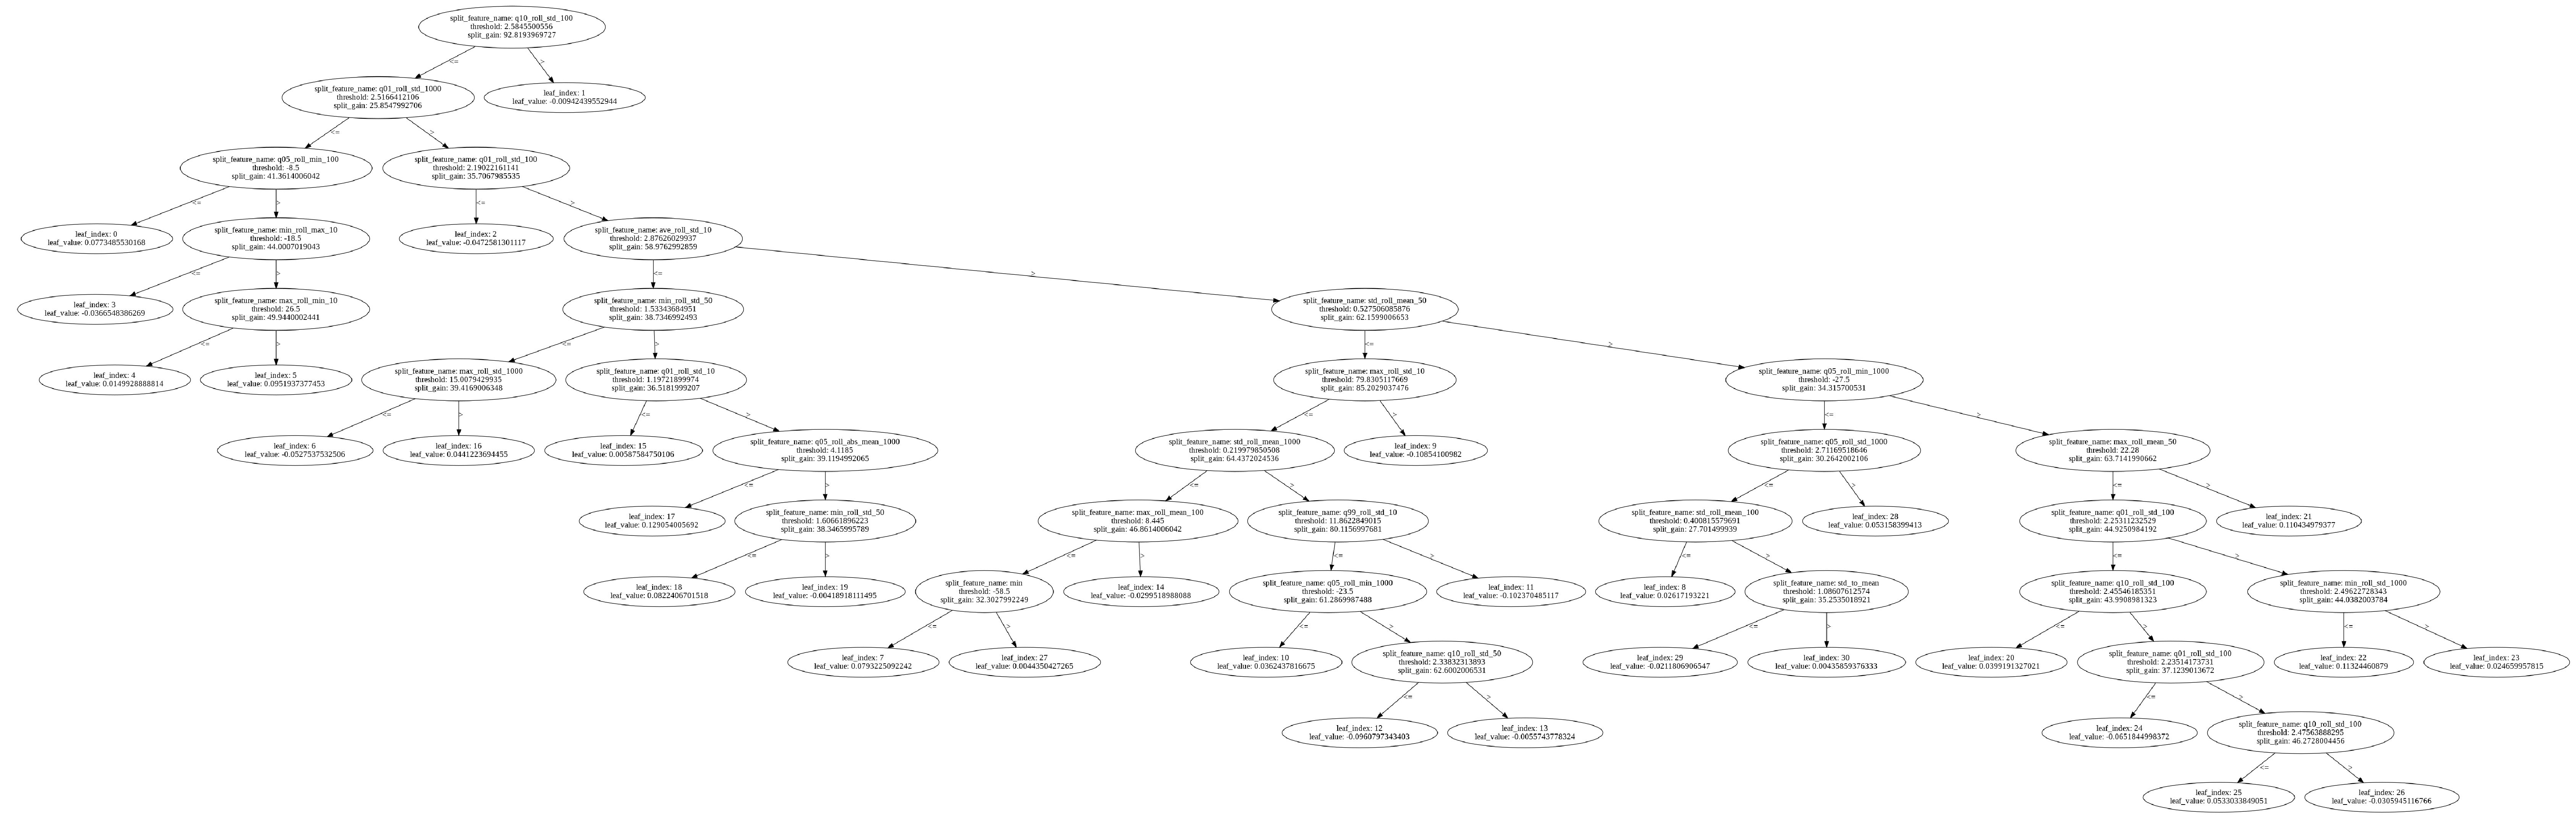

In [56]:
print "LightGBM"
print('Plotting metrics recorded during training...')
ax = lightgbm.plot_metric(evals_result, metric='huber')
plt.show()
print('Plotting feature importances...')

fig, ax = plt.subplots(figsize=(5, 10))
ax = lightgbm.plot_importance(gbm, max_num_features=10, ax=ax)
plt.show()
print('Plotting tree with graphviz...')
graph = lightgbm.create_tree_digraph(gbm, tree_index=0, name='Tree')
graph.render(view=True)
#print('Plotting 54th tree...')  # one tree use categorical feature to split
ax = lightgbm.plot_tree(gbm, tree_index=53, figsize=(120, 120), show_info=['split_gain'])
plt.show()

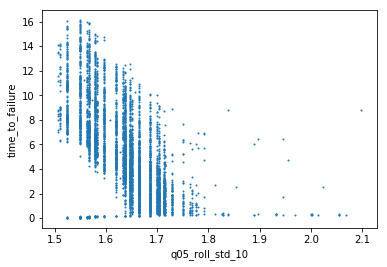

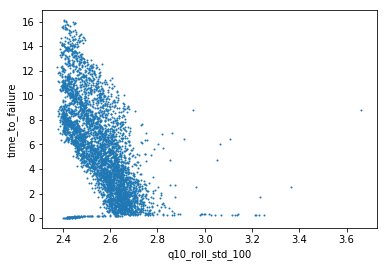

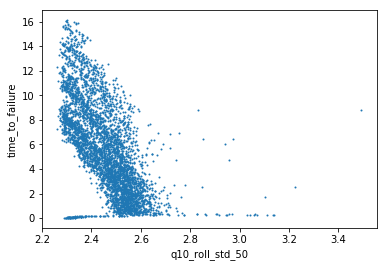

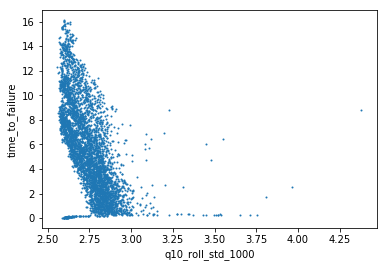

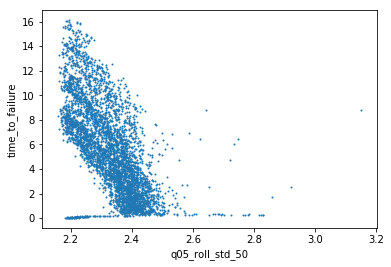

In [57]:
#keys = X.keys()
#keys = ['min_roll_std_24', 'min_roll_std_120', 'q25_roll_std_1000', 'min_roll_std_80', 'trend', 'min_roll_std_50', 'min_roll_std_20', 'std_roll_mean_48', 'std_roll_mean_1000', 'min_roll_std_1000']
keys = ['q05_roll_std_10', 'q10_roll_std_100', 'q10_roll_std_50', 'q10_roll_std_1000', 'q05_roll_std_50']
xyz = [[ plt.scatter(X[key], Y, s=1), plt.xlabel(key), plt.ylabel('time_to_failure'),plt.show()] for i, key in enumerate(keys)]
#plt.scatter(raw_sample['acoustic_data'], raw_sample['time_to_failure'], s=1)
